## Anyone can Learn To Code an LSTM-RNN in Python
원문 링크: https://iamtrask.github.io/2015/11/15/anyone-can-code-lstm/

번역 링크: http://jaejunyoo.blogspot.com/2017/06/anyone-can-learn-to-code-LSTM-RNN-Python.html

### [목표]
* 간단한 toy code로 RNN을 이해한다. 
* RNN을 사용하여 이진수 더하기 연산을 학습시킨다.


In [1]:
# 간단한 library들 import
import copy, numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)
%matplotlib inline

In [2]:
# Utility function
def sigmoid(x):
    output =1/(1+np.exp(-x))
    return output

def sigmoid_output_to_derivative(output):    
    return output*(1-output)

In [3]:
# 최대 이진수의 범위를 8 byte로 한정
max_binary_dim = 8
largest_number = pow(2,max_binary_dim)
#print(2**8)
#print(pow(2,max_binary_dim))
#print(range(2**3))

## Create binary lookup table

In [4]:
# binary lookup table 만들기 (그저 편의상 만들뿐 굳이 이런 식으로 하지 않아도 됨)
# np.unpackbits 예시
print(np.unpackbits(np.array([8], dtype = np.uint8)))
print("====================")
# 이진수로 만들 정수 값들 1~256을 list in list 형태로 만듬.
# e.g
# binary_gonna_be = np.array([range(largest_number)], dtype=np.uint8).T
# print(binary_gonna_be)

# 이런 식으로  binary lookup table 완성
binary = np.unpackbits(np.array([range(largest_number)], dtype=np.uint8).T, axis = 1)
print(binary.shape, binary)
print("====================")
int2binary = {}
for i in range(largest_number):
    int2binary[i] = binary[i]
print("lookup table test")
print(binary[3], int2binary[3])
#print(int2binary)

[0 0 0 0 1 0 0 0]
(256, 8) [[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 1]
 [0 0 0 ..., 0 1 0]
 ..., 
 [1 1 1 ..., 1 0 1]
 [1 1 1 ..., 1 1 0]
 [1 1 1 ..., 1 1 1]]
lookup table test
[0 0 0 0 0 0 1 1] [0 0 0 0 0 0 1 1]


## Initial parameter setting

In [5]:
alpha = 0.1 # learning rate
input_dim = 2 # 각 자리수끼리 더할 것이므로 서로 더할 두 이진수의 n번째 자리에 해당하는 digit 두 개가 input이 됨
hidden_dim = 16 # 바꾸면서 성능이 어떻게 변하는지 확인해보면서 놀아보자
output_dim = 1 # output은 결국 n번째 자리의 digit 두 개가 합해서 나올 값이므로 one dim이 된다. e.g. 1(2) + 1(2) = 0(2) with overflow 1

# weight initialization
synapse_0 = 2*np.random.random((input_dim,hidden_dim))-1
synapse_1 = 2*np.random.random((hidden_dim,output_dim))-1
synapse_h = 2*np.random.random((hidden_dim,hidden_dim))-1

print(synapse_0.shape, synapse_1.shape, synapse_h.shape)

(2, 16) (16, 1) (16, 16)


In [6]:
# saving for updates and visualization
s0_update = np.zeros(synapse_0.shape) # s0_update = np.zeros_like(synapse_0)
s1_update = np.zeros(synapse_1.shape) 
sh_update = np.zeros(synapse_h.shape) 

overallError_history = list()
accuracy = list()
accuracy_history = list()
accuracy_count = 0

## training!!

In [7]:
for j in range(10000):
    # 랜덤하게 정수 두 개를 뽑은 후 binary lookup table에서 해당 이진수 가져오기.
    a_int = np.random.randint(1,largest_number//2)
    a = int2binary[a_int]
    b_int = np.random.randint(1,largest_number//2)
    b = int2binary[b_int]
    # 실제 정답 계산 및 binary 벡터 저장.
    c_int = a_int + b_int
    c = int2binary[c_int]
    
    # RNN이 예측한 binary 합의 값 저장할 변수 선언.
    pred = np.zeros_like(c)
    
    overallError = 0
    
    output_layer_deltas = list()
    hidden_layer_values = list()
    hidden_layer_values.append(np.zeros(hidden_dim)) # dim: (1, 16)

    # feed forward !
    # 이진수의 가장 낮은 자리수부터 시작해야하므로 reversed로 for문 돌림.
    for position in reversed(range(max_binary_dim)):
        
        # RNN에 들어갈 input과 output label 이진수 값 가져오기
        X = np.array([[a[position],b[position]]]) # dim: (1, 2), e.g. [[1,0]]
        y = np.array([[c[position]]]) # dim: (1, 1), e.g. [[1]]
        
        # hidden layer 계산하기 h_t = sigmoid(X*W_{hx} + h_{t-1}*W_{hh})
        hidden_layer = sigmoid(np.dot(X,synapse_0) + np.dot(hidden_layer_values[-1],synapse_h)) # dim: (1, 16)
        
        # output_layer 계산하기       
        output_layer = sigmoid(np.dot(hidden_layer,synapse_1)) # dim: (1, 1), e.g. [[0.47174173]]
        
        # error 값 계산
        output_layer_error = y-output_layer # dim: (1, 1) 
        
        # display를 위한 저장
        overallError += np.abs(output_layer_error[0]) # dim: (1, )          
        
        # 이 후 backpropagation에서 사용될 delta 값 미리 계산하여 저장
        output_layer_deltas.append((output_layer_error) * sigmoid_output_to_derivative(output_layer))        
        
        # 현재 자리수에 대한 예측값 저장
        pred[position] = np.round(output_layer[0][0])
        
        # 현재까지 계산된 hidden layer 저장
        hidden_layer_values.append(copy.deepcopy(hidden_layer)) 
    
    if (j%100 == 0):
        overallError_history.append(overallError[0])
    
    # 이제 backpropagation !
        
    # 맨 처음 시작할 때는 현재 시점보다 앞에 있는 hidden layer가 없으므로 delta 값이 0임.  
    future_hidden_layer_delta = np.zeros(hidden_dim)
    
    # backpropagation을 할 때는 이진수의 가장 앞자리수 시점부터 돌아와야 하므로 정상적인 for문
    for position in range(max_binary_dim):
        
        # 필요한 값들 다시 불러오고
        X = np.array([[a[position],b[position]]])
        hidden_layer = hidden_layer_values[-position-1]
        prev_hidden_layer = hidden_layer_values[-position-2]
        
        # 현재 시점에서 output layer error로부터 돌아오는 gradient 값
        output_layer_delta = output_layer_deltas[-position-1]
        
        # 현재 시점의 hidden layer에 더해진 gradient를 계산하기 위해서는
        # 이전 시점의 hidden layer로부터 돌아오는 error gradient + 현재 시점 output layer로부터 돌아오는 error gradient
        # 이 둘의 합에 sigmoid의 derivative 계산해줘야 함
        # 이유: h_t = sigmoid(X*W_{hx} + h_{t-1}*W_{hh})를 역전파 하는 것을 생각하면 됨.
        hidden_layer_delta = (np.dot(future_hidden_layer_delta,synapse_h.T) + np.dot(output_layer_delta,synapse_1.T)) \
                            * sigmoid_output_to_derivative(hidden_layer)
        
        # 8자리 모두를 다 계산한 후 gradient의 합을 한 번에 update 해준다. 
        # 이유: backprop이 아직 다 끝나지 않았는데 중간에 hidden layer의 value가 바뀌면 안됨
        s1_update += np.atleast_2d(hidden_layer).T.dot(output_layer_delta)
        sh_update += np.atleast_2d(prev_hidden_layer).T.dot(hidden_layer_delta)
        s0_update += X.T.dot(hidden_layer_delta)
        
        # 다음 position으로 넘어가면 현재 hidden_layer_delta가 future step이 되므로 이를 넣어준다.
        future_hidden_layer_delta = hidden_layer_delta

    # weight 값들 update (learning rate를 곱하여)
    synapse_1 += s1_update*alpha
    synapse_0 += s0_update*alpha
    synapse_h += sh_update*alpha
    
    # update 값들 초기화 (새로운 a,b training 이진수에 대해 계산을 해줘야하므로)
    s1_update *= 0
    s0_update *= 0    
    sh_update *= 0
    
    # accuracy 계산
    check = np.equal(pred,c)
    if np.sum(check) == max_binary_dim:
        accuracy_count += 1
    if (j%100 == 0):
        accuracy_history.append(accuracy_count)
        accuracy_count = 0
    
    
    if (j % 100 == 0):
        print ("Error:" + str(overallError))
        print ("Pred:" + str(pred))  # 예측값
        print ("True:" + str(c))  # 실제값

        final_check = np.equal(pred,c)
        print (np.sum(final_check) == max_binary_dim)

        out = 0

        for index, x in enumerate(reversed(pred)):
            out += x * pow(2, index)
        print (str(a_int) + " + " + str(b_int) + " = " + str(out))
        print ("------------")

Error:[ 3.97540736]
Pred:[0 0 0 0 0 0 0 0]
True:[0 1 0 0 0 1 1 1]
False
10 + 61 = 0
------------
Error:[ 4.0325467]
Pred:[0 1 1 0 1 1 0 1]
True:[1 0 0 1 0 1 0 1]
False
111 + 38 = 109
------------
Error:[ 3.79424599]
Pred:[0 0 0 0 0 0 0 0]
True:[0 0 1 1 1 0 0 0]
False
55 + 1 = 0
------------
Error:[ 3.87395152]
Pred:[0 0 0 0 0 0 0 0]
True:[0 0 0 1 1 0 0 1]
False
20 + 5 = 0
------------
Error:[ 4.01458433]
Pred:[1 1 1 1 1 1 1 1]
True:[0 1 0 1 0 1 1 0]
False
12 + 74 = 255
------------
Error:[ 3.99141219]
Pred:[0 0 0 0 0 0 0 0]
True:[0 1 1 0 0 0 1 0]
False
30 + 68 = 0
------------
Error:[ 3.97121353]
Pred:[0 0 0 0 1 0 0 0]
True:[0 0 1 0 0 0 0 1]
False
28 + 5 = 8
------------
Error:[ 4.02250446]
Pred:[1 1 1 1 1 1 1 0]
True:[0 1 0 1 1 0 1 1]
False
60 + 31 = 254
------------
Error:[ 4.04634296]
Pred:[1 1 0 1 0 1 0 1]
True:[0 1 1 1 1 1 1 1]
False
23 + 104 = 213
------------
Error:[ 3.87790083]
Pred:[1 0 1 1 1 1 1 0]
True:[1 1 0 1 0 1 1 0]
False
124 + 90 = 190
------------
Error:[ 3.8993887]
Pr

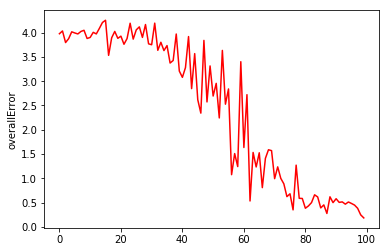

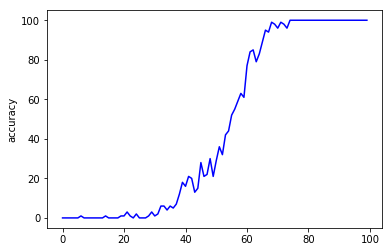

In [8]:
#print(overallError_history)
x_range = range(100)
plt.plot(x_range,overallError_history,'r-')
plt.ylabel('overallError')
plt.show()

plt.plot(x_range,accuracy_history,'b-')
plt.ylabel('accuracy')
plt.show()